In [1]:
# Import required modules
import scanpy as sc
import scvelo as scv
import leidenalg
scv.logging.print_version()

import numpy as np
import pandas as pd
import seaborn as sns
import igraph
import matplotlib.pyplot as plt

Running scvelo 0.2.4 (python 3.9.7) on 2024-10-16 16:44.


In [2]:
sc.settings.verbosity = 3    
sc.logging.print_versions() 
sc.settings.set_figure_params(dpi=80, facecolor='white') 

-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                         9.0.1
asttokens                   NA
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
bottleneck                  1.3.4
cffi                        1.15.0
cloudpickle                 2.0.0
colorama                    0.4.4
cycler                      0.10.0
cython_runtime              NA
cytoolz                     0.11.0
dask                        2022.05.0
dateutil                    2.8.2
debugpy                     1.5.1
decorator                   5.1.1
defusedxml                  0.7.1
executing                   0.8.3
fsspec                      2022.3.0
google                      NA
h5py                        3.1.0
igraph                      0.9.10
ipykernel                   6.9.1
ipython_genutils            0.2.0
ipywidgets                  7.6.5
jedi                        0.18.1
jinja2                      2.11.3
joblib                      1.1.0
ju

In [3]:
#########################################
#              RNA velocity
#########################################

In [4]:
# Import the combined loom file (including samples from enriched B, BMMC, Zhang et al and Zhu et al)
# Note, King et al (GC B cells) were not included due to the incompleteness of their published data
loom_file = 'loom_data/combined.loom'
adataR = scv.read(loom_file, cache=True)

... reading from cache file cache/loom_data-combined.h5ad


In [5]:
# Check the import data
adataR

AnnData object with n_obs × n_vars = 229680 × 36601
    obs: 'Clusters', '_X', '_Y'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [6]:
# Check the metadata of import cells
adataR.obs

,Clusters,_X,_Y
CellID,,,
R-TAN-BB2:AAACCTGGTCTAGTGTx,7,40.906551,20.219009
R-TAN-BB2:AAAGATGGTACAGCAGx,0,12.837214,21.599703
R-TAN-BB2:AAACGGGGTCACCTAAx,1,7.917360,-28.980621
R-TAN-BB2:AAACCTGTCCCTCAGTx,1,22.895107,-23.123066
R-TAN-BB2:AAACGGGGTAAGAGAGx,1,10.291541,-16.213812
...,...,...,...
R-CHEN-BB2:TTTGGTTCAATCTACGx,16,42.013939,-4.750619
R-CHEN-BB2:TTTGGTTCACAGACAGx,12,24.704977,-7.056959
R-CHEN-BB2:TTTGGTTAGAATAGGGx,5,2.675356,37.802067


In [7]:
######## Import cell metadata

In [11]:
df_cell_meta = pd.read_csv('../Tables/bc.proj.clean.metadata.20230921.csv', index_col=0)
df_cell_meta

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,sample,donor,batch,seurat_clusters,cell_type,integrated_snn_res.0.8,...,subclass,isotype,integrated_snn_res.1,cell_group,RNA_snn_res.0.8,Sample,seurat_clusters_0.8,seurat_clusters_1.0,CellType,CellTypeGamma
hd1.cd34_AAACCCAGTGGAAGTC-1,BM_CD34,9717,3040,4.665710,hd1.cd34,NaN,NaN,20,NaN,20,...,Unknown,Unknown,21,B lineage,22,hd1.cd34,20,21,Pre-pro B,Pre-pro B
hd1.cd34_AAACGAAAGCTATCTG-1,BM_CD34,4413,1785,3.922453,hd1.cd34,NaN,NaN,20,NaN,20,...,Unknown,Unknown,21,B lineage,22,hd1.cd34,20,21,Pre-pro B,Pre-pro B
hd1.cd34_AAACGCTAGAAGGCTC-1,BM_CD34,5593,1979,6.625111,hd1.cd34,NaN,NaN,20,NaN,20,...,Unknown,Unknown,21,B lineage,22,hd1.cd34,20,21,Pre-pro B,Pre-pro B
hd1.cd34_AAACGCTAGGAAGAAC-1,BM_CD34,4537,1799,5.847439,hd1.cd34,NaN,NaN,20,NaN,20,...,Unknown,Unknown,21,B lineage,22,hd1.cd34,20,21,Pre-pro B,Pre-pro B
hd1.cd34_AAACGCTGTGCCTGAC-1,BM_CD34,4583,1801,7.250163,hd1.cd34,NaN,NaN,20,NaN,20,...,Unknown,Unknown,21,B lineage,22,hd1.cd34,20,21,Pre-pro B,Pre-pro B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R-TAN-PB-TTTGGTTTCCATGCTC-1,Enriched B,4063,1708,2.018213,TAN-PB,TAN,NaN,7,NaN,7,...,IGHM,IGHM,8,B lineage,11,TAN-PB,7,8,FOShi naive B,FOShi naive B
R-TAN-PB-TTTGTCAAGGCTCAGA-1,Enriched B,3825,2020,7.346405,TAN-PB,TAN,NaN,13,NaN,13,...,Unknown,Unknown,14,B lineage,14,TAN-PB,13,14,CD27-IgM+IgD+ memory B,CD27-IgM+IgD+ memory B
R-TAN-PB-TTTGTCAAGTTCGATC-1,Enriched B,4455,1628,2.558923,TAN-PB,TAN,NaN,13,NaN,13,...,IGHM,IGHM,14,B lineage,14,TAN-PB,13,14,CD27-IgM+IgD+ memory B,CD27-IgM+IgD+ memory B
R-TAN-PB-TTTGTCAGTACTTAGC-1,Enriched B,1936,968,2.840909,TAN-PB,TAN,NaN,7,NaN,7,...,IGHM,IGHM,8,B lineage,11,TAN-PB,7,8,FOShi naive B,FOShi naive B


In [12]:
# Check the list of projects
df_cell_meta["Project"].unique()

array(['Zhang et al', 'BMMC', 'Zhu et al', 'King et al', 'Enriched B'],
      dtype=object)

In [13]:
# Check the nomenclature of cell barcodes in different projects

In [14]:
set([x.split("_")[0] for x in df_cell_meta[df_cell_meta["Project"]=="Zhang et al"].index])

{'hd1.cd19', 'hd1.cd34', 'hd2.cd19', 'hd2.cd34'}

In [15]:
set(["-".join(x.split("-")[:3]) for x in df_cell_meta[df_cell_meta["Project"]=="BMMC"].index])

{'R-CHEN-BM1',
 'R-CHEN-BM2',
 'R-DENG-BM1',
 'R-DENG-BM2',
 'R-TAN-BM1',
 'R-TAN-BM2'}

In [16]:
set(["-".join(x.split("-")[:3]) for x in df_cell_meta[df_cell_meta["Project"]=="Enriched B"].index])

{'R-CHEN-BB1',
 'R-CHEN-BB2',
 'R-CHEN-BB3',
 'R-CHEN-PB',
 'R-DENG-BB1',
 'R-DENG-BB2',
 'R-DENG-BB3',
 'R-DENG-PB',
 'R-TAN-BB1',
 'R-TAN-BB2',
 'R-TAN-BB3',
 'R-TAN-PB'}

In [17]:
set(["_".join(x.split("_")[:2]) for x in df_cell_meta[df_cell_meta["Project"]=="King et al"].index])

{'BCP002_total',
 'BCP003_total',
 'BCP004_total',
 'BCP005_total',
 'BCP006_total',
 'BCP008_total',
 'BCP009_total'}

In [18]:
# Check the suffix of cell barcodes in Zhu et al
set(x.split("_")[1] for x in df_cell_meta[df_cell_meta["Project"]=="Zhu et al"].index)

{'1', '10', '2'}

In [19]:
# Check the overlap of barcodes after barcode name conversion
set2 = set([x.split(":")[0]+"-"+x.split(":")[1][:-1] for x in adataR.obs_names if x.startswith("CTRL")])
set1 = set(df_cell_meta[df_cell_meta.Project=="Zhu et al"].apply(lambda x:"CTRL"+x.batch.split("-")[1]+"-"+x.name.split("_")[0][4:], axis=1).tolist())
set1 - set2

{'CTRL3-GATATTGTACATAGGC'}

In [20]:
# Generate a dictionary to map the short barcodes to longer ones
keys = df_cell_meta[df_cell_meta.Project=="Zhu et al"].apply(lambda x:"CTRL"+x.batch.split("-")[1]+"-"+x.name.split("_")[0][4:], axis=1).tolist()
values = df_cell_meta[df_cell_meta.Project=="Zhu et al"].index.tolist()
id_dict = dict(zip(keys, values))
id_dict

{'CTRL1-GAGTCCATCAGTTAAC': 'CTAAGAGTCCATCAGTTAAC_1',
 'CTRL1-ATGATGTCGCATCTTG': 'GATAATGATGTCGCATCTTG_1',
 'CTRL1-CCAAGCATTATTGTGC': 'GGCTCCAAGCATTATTGTGC_1',
 'CTRL1-AGTGGAGTTGCGCCGG': 'AATCAGTGGAGTTGCGCCGG_1',
 'CTRL1-GTACCATGTGTAGCCG': 'GTCAGTACCATGTGTAGCCG_1',
 'CTRL1-CACAGGCGAGGTTAAC': 'ACTGCACAGGCGAGGTTAAC_1',
 'CTRL1-ACTACACTTACCGGTG': 'TTCCACTACACTTACCGGTG_1',
 'CTRL1-CAATAGTGTGTGTAAC': 'GCCGCAATAGTGTGTGTAAC_1',
 'CTRL1-TATCGTACGACGTCCA': 'AGTCTATCGTACGACGTCCA_1',
 'CTRL1-ATAGGCTTACCAAGGT': 'GTACATAGGCTTACCAAGGT_1',
 'CTRL1-TCCTATTCTTCATCTC': 'AGCCTCCTATTCTTCATCTC_1',
 'CTRL1-AGTTGGCCGAATCAGT': 'CATCAGTTGGCCGAATCAGT_1',
 'CTRL1-TCGGTGACATATGCGA': 'GACATCGGTGACATATGCGA_1',
 'CTRL1-TCTTAATTCTCACTCC': 'TTGATCTTAATTCTCACTCC_1',
 'CTRL1-CAGGAATGCAGTGGTA': 'TACTCAGGAATGCAGTGGTA_1',
 'CTRL1-CGTGCGTCGTAGTCGT': 'ATGGCGTGCGTCGTAGTCGT_1',
 'CTRL1-CTACGAATTATTGTGC': 'CGTTCTACGAATTATTGTGC_1',
 'CTRL1-AGAGGTTCCGTGAAGC': 'GATGAGAGGTTCCGTGAAGC_1',
 'CTRL1-CAACCTGCGTACAACT': 'GGTGCAACCTGCGTACAA

In [21]:
# Define a function to map barcodes in `loom` file onto the barcodes in the metadata table
def id_mapping(x):
    if x.startswith("R"):
        return x.split(":")[0]+"-"+x.split(":")[1][:-1]+"-1"
    elif x.startswith("HRR178258"):
        return "hd1.cd19_"+x.split(":")[1][:-1]+"-1"
    elif x.startswith("HRR178259"):
        return "hd2.cd19_"+x.split(":")[1][:-1]+"-1"
    elif x.startswith("HRR178260"):
        return "hd1.cd34_"+x.split(":")[1][:-1]+"-1"
    elif x.startswith("HRR178261"):
        return "hd2.cd34_"+x.split(":")[1][:-1]+"-1"
    
    elif x.startswith("CTRL"):
        id_conv = x.split(":")[0]+"-"+x.split(":")[1][:-1]
        if id_conv in id_dict.keys():
            return id_dict[id_conv]
        else:
            return x
    
    else:
        return x
    
    

In [22]:
# Check the total number of overlap barcodes after name conversion
len(set(df_cell_meta.index.tolist()) & set(pd.Series(adataR.obs_names).apply(lambda x:id_mapping(x))))

112856

In [23]:
# Store the overlapped barcodes in a variable
overlap_bar = list(set(df_cell_meta.index.tolist()) & set(pd.Series(adataR.obs_names).apply(lambda x:id_mapping(x))))

In [24]:
# Check the total number of barcodes in the metadata after removing cells from King et al
df_cell_meta[(df_cell_meta.Project!="King et al")].shape

(112857, 28)

In [25]:
# Check the missing barcodes (The result showed that only one cell barcode was missed in the loom file)
df_cell_meta[(df_cell_meta.Project!="King et al") & ~df_cell_meta.index.isin(overlap_bar)]

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,sample,donor,batch,seurat_clusters,cell_type,integrated_snn_res.0.8,...,subclass,isotype,integrated_snn_res.1,cell_group,RNA_snn_res.0.8,Sample,seurat_clusters_0.8,seurat_clusters_1.0,CellType,CellTypeGamma
CTAAGATATTGTACATAGGC_10,SeuratProject,637,397,4.55259,NaN,NaN,Ctrl-3,15,Plasma,15,...,Unknown,Unknown,15,B lineage,20,Ctrl-3,15,15,PC,PB


In [26]:
# Check the sample nomenclature in the loom file
set([x.split(":")[0] for x in adataR.obs.index])

{'CTRL1',
 'CTRL2',
 'CTRL3',
 'HRR178258',
 'HRR178259',
 'HRR178260',
 'HRR178261',
 'R-CHEN-BB1',
 'R-CHEN-BB2',
 'R-CHEN-BB3',
 'R-CHEN-BM1',
 'R-CHEN-BM2',
 'R-CHEN-PB',
 'R-DENG-BB1',
 'R-DENG-BB2',
 'R-DENG-BB3',
 'R-DENG-BM1',
 'R-DENG-BM2',
 'R-DENG-PB',
 'R-TAN-BB1',
 'R-TAN-BB2',
 'R-TAN-BB3',
 'R-TAN-BM1',
 'R-TAN-BM2',
 'R-TAN-PB'}

In [27]:
# Filter the adataR to retain only the overlapped cells
adataR = adataR[pd.Series(adataR.obs_names).apply(lambda x:id_mapping(x)).isin(overlap_bar),:]
adataR

View of AnnData object with n_obs × n_vars = 112856 × 36601
    obs: 'Clusters', '_X', '_Y'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [28]:
# Perform cell name conversion
adataR.obs_names = pd.Series(adataR.obs_names).apply(lambda x:id_mapping(x))
adataR.obs

,Clusters,_X,_Y
CellID,,,
R-TAN-BB2-AAACCTGGTCTAGTGT-1,7,40.906551,20.219009
R-TAN-BB2-AAAGATGGTACAGCAG-1,0,12.837214,21.599703
R-TAN-BB2-AAACGGGGTCACCTAA-1,1,7.917360,-28.980621
R-TAN-BB2-AAACCTGTCCCTCAGT-1,1,22.895107,-23.123066
R-TAN-BB2-AAACCTGGTGATAAGT-1,2,-10.515806,22.304138
...,...,...,...
R-CHEN-BB2-TTTGCGCGTACCGAGA-1,8,38.901100,-25.747307
R-CHEN-BB2-TTTGCGCGTTCCACGG-1,11,0.562139,-18.388870
R-CHEN-BB2-TTTGCGCAGGATTCGG-1,7,-0.220377,-40.162304


In [29]:
# Load preprocessed object (derived from R object)
adata = sc.read_h5ad("../bc.proj.clean.h5ad")

In [30]:
adata

AnnData object with n_obs × n_vars = 135250 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'sample', 'donor', 'batch', 'seurat_clusters', 'cell_type', 'integrated_snn_res.0.8', 'Stage', 'tissue', 'Project', 'Tissue', 'S.Score', 'G2M.Score', 'Phase', 'singleR', 'subclass', 'isotype', 'integrated_snn_res.1', 'cell_group', 'RNA_snn_res.0.8', 'Sample', 'seurat_clusters_0.8', 'seurat_clusters_1.0', 'CellType', 'scVDJ'
    var: 'features'
    uns: 'neighbors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances'

In [31]:
len(set(adata.obs_names) & set(df_cell_meta.index))

134599

In [32]:
adata = adata[adata.obs_names.isin(df_cell_meta.index.tolist())]
adata

View of AnnData object with n_obs × n_vars = 134599 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'sample', 'donor', 'batch', 'seurat_clusters', 'cell_type', 'integrated_snn_res.0.8', 'Stage', 'tissue', 'Project', 'Tissue', 'S.Score', 'G2M.Score', 'Phase', 'singleR', 'subclass', 'isotype', 'integrated_snn_res.1', 'cell_group', 'RNA_snn_res.0.8', 'Sample', 'seurat_clusters_0.8', 'seurat_clusters_1.0', 'CellType', 'scVDJ'
    var: 'features'
    uns: 'neighbors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances'

In [33]:
# Assign cell type info to adata
ct_dict = df_cell_meta.CellTypeGamma.to_dict()
adata.obs["CellType"] = [ct_dict[x] for x in adata.obs_names]
adata.obs

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,sample,donor,batch,seurat_clusters,cell_type,integrated_snn_res.0.8,...,subclass,isotype,integrated_snn_res.1,cell_group,RNA_snn_res.0.8,Sample,seurat_clusters_0.8,seurat_clusters_1.0,CellType,scVDJ
hd1.cd34_AAACCCAGTGGAAGTC-1,BM_CD34,9717.0,3040,4.665710,hd1.cd34,NA,NA,20,NA,13,...,Unknown,Unknown,14,B lineage,22,hd1.cd34,20,21,Pre-pro B,0
hd1.cd34_AAACGAAAGCTATCTG-1,BM_CD34,4413.0,1785,3.922453,hd1.cd34,NA,NA,20,NA,13,...,Unknown,Unknown,14,B lineage,22,hd1.cd34,20,21,Pre-pro B,0
hd1.cd34_AAACGCTAGAAGGCTC-1,BM_CD34,5593.0,1979,6.625111,hd1.cd34,NA,NA,20,NA,13,...,Unknown,Unknown,14,B lineage,22,hd1.cd34,20,21,Pre-pro B,0
hd1.cd34_AAACGCTAGGAAGAAC-1,BM_CD34,4537.0,1799,5.847439,hd1.cd34,NA,NA,20,NA,13,...,Unknown,Unknown,14,B lineage,22,hd1.cd34,20,21,Pre-pro B,0
hd1.cd34_AAACGCTGTGCCTGAC-1,BM_CD34,4583.0,1801,7.250163,hd1.cd34,NA,NA,20,NA,13,...,Unknown,Unknown,14,B lineage,22,hd1.cd34,20,21,Pre-pro B,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R-TAN-PB-TTTGGTTTCCATGCTC-1,Enriched B,4063.0,1708,2.018213,TAN-PB,TAN,NA,7,NA,23,...,IGHM,IGHM,26,B lineage,11,TAN-PB,7,8,FOShi naive B,1
R-TAN-PB-TTTGTCAAGGCTCAGA-1,Enriched B,3825.0,2020,7.346405,TAN-PB,TAN,NA,13,NA,5,...,Unknown,Unknown,6,B lineage,14,TAN-PB,13,14,CD27-IgM+IgD+ memory B,0
R-TAN-PB-TTTGTCAAGTTCGATC-1,Enriched B,4455.0,1628,2.558923,TAN-PB,TAN,NA,13,NA,5,...,IGHM,IGHM,6,B lineage,14,TAN-PB,13,14,CD27-IgM+IgD+ memory B,1
R-TAN-PB-TTTGTCAGTACTTAGC-1,Enriched B,1936.0,968,2.840909,TAN-PB,TAN,NA,7,NA,23,...,IGHM,IGHM,26,B lineage,11,TAN-PB,7,8,FOShi naive B,1


In [34]:
# Filter the adata to retained only the overlapped barcodes
adata = adata[adata.obs_names.isin(overlap_bar),]
adata

View of AnnData object with n_obs × n_vars = 112856 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'sample', 'donor', 'batch', 'seurat_clusters', 'cell_type', 'integrated_snn_res.0.8', 'Stage', 'tissue', 'Project', 'Tissue', 'S.Score', 'G2M.Score', 'Phase', 'singleR', 'subclass', 'isotype', 'integrated_snn_res.1', 'cell_group', 'RNA_snn_res.0.8', 'Sample', 'seurat_clusters_0.8', 'seurat_clusters_1.0', 'CellType', 'scVDJ'
    var: 'features'
    uns: 'neighbors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances'

In [35]:
# Merge the velocyte object and preprocessed object
adata_merge = scv.utils.merge(adataR, adata)
adata_merge

AnnData object with n_obs × n_vars = 112856 × 1998
    obs: 'Clusters', '_X', '_Y', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'sample', 'donor', 'batch', 'seurat_clusters', 'cell_type', 'integrated_snn_res.0.8', 'Stage', 'tissue', 'Project', 'Tissue', 'S.Score', 'G2M.Score', 'Phase', 'singleR', 'subclass', 'isotype', 'integrated_snn_res.1', 'cell_group', 'RNA_snn_res.0.8', 'Sample', 'seurat_clusters_0.8', 'seurat_clusters_1.0', 'CellType', 'scVDJ'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'features'
    uns: 'neighbors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [36]:
# Computes moments for velocity estimation
# First-/second-order moments are computed for each cell across its nearest neighbors, 
# where the neighbor graph is obtained from euclidean distances in PCA space.
scv.pp.moments(adata_merge)

Normalized count data: X, spliced, unspliced.
computing neighbors
    finished (0:00:50) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:15) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [37]:
# Estimate RNA velocity
scv.tl.velocity(adata_merge, mode='stochastic')

computing velocities
    finished (0:00:57) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [38]:
# In order to project the velocities into a lower-dimensional embedding, 
# transition probabilities of cell-to-cell transitions are estimated. 
# That is, for each velocity vector we find the likely cell transitions 
# that are accordance with that direction. The transition probabilities 
# are computed using cosine correlation between the potential cell-to-cell 
# transitions and the velocity vector, and are stored in a matrix denoted 
# as velocity graph. The resulting velocity graph has dimension nobs×nobs 
# and summarizes the possible cell state changes that are well explained 
# through the velocity vectors
scv.tl.velocity_graph(adata_merge, n_jobs=50)

computing velocity graph (using 50/80 cores)


  0%|          | 0/112856 [00:00<?, ?cells/s]

    finished (0:02:20) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [39]:
# Set the category of CellType column and reorder cell types
from pandas.api.types import CategoricalDtype
cell_order = ["Pre-pro B", "Cycling pro B", "Pro B", 
               "Cycling pre B", "Pre B", 
               "Immature B", "FTLhi immature B", "S100A8hi immature B",
               "Naive B", "FOShi naive B", "HSPA1Ahi naive B",
               "LZ GC B", "DZ GC B", 
               "Classical memory B", "IgM+ memory B", "CD27-IgM+IgD+ memory B", "PB", "PC"]

cat_type = CategoricalDtype(categories=cell_order, ordered=True)
adata_merge.obs["CellType"] = adata_merge.obs.CellType.astype(cat_type)
adata_merge.obs.CellType

CellID
R-TAN-BB2-AAACCTGGTCTAGTGT-1        IgM+ memory B
R-TAN-BB2-AAAGATGGTACAGCAG-1              Naive B
R-TAN-BB2-AAACGGGGTCACCTAA-1           Immature B
R-TAN-BB2-AAACCTGTCCCTCAGT-1              Naive B
R-TAN-BB2-AAACCTGGTGATAAGT-1              Naive B
                                       ...       
R-CHEN-BB2-TTTGCGCGTACCGAGA-1    FTLhi immature B
R-CHEN-BB2-TTTGCGCGTTCCACGG-1             Naive B
R-CHEN-BB2-TTTGCGCAGGATTCGG-1             Naive B
R-CHEN-BB2-TTTGGTTCACAGACAG-1                  PC
R-CHEN-BB2-TTTGTCAGTCTGGAGA-1             Naive B
Name: CellType, Length: 112856, dtype: category
Categories (18, object): ['Pre-pro B' < 'Cycling pro B' < 'Pro B' < 'Cycling pre B' ... 'IgM+ memory B' < 'CD27-IgM+IgD+ memory B' < 'PB' < 'PC']

In [40]:
# Customize the color scheme
color_lst = ["#e7dfd5", "#d04925", "#84a9ac", "#992e24", "#3b6978", 
          "#62cdff", "#97deff", "#c9eeff", "#14c38e", "#b8f1b0", "#e3fcbf", 
          "#f9c5d5",  "#f2789f", "#40128b", "#9336b4", 
          "#dd58d6",  "#f6ba6f", "#f9d923"]
adata_merge.uns["CellType_colors"] = color_lst


computing velocity embedding
    finished (0:00:48) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


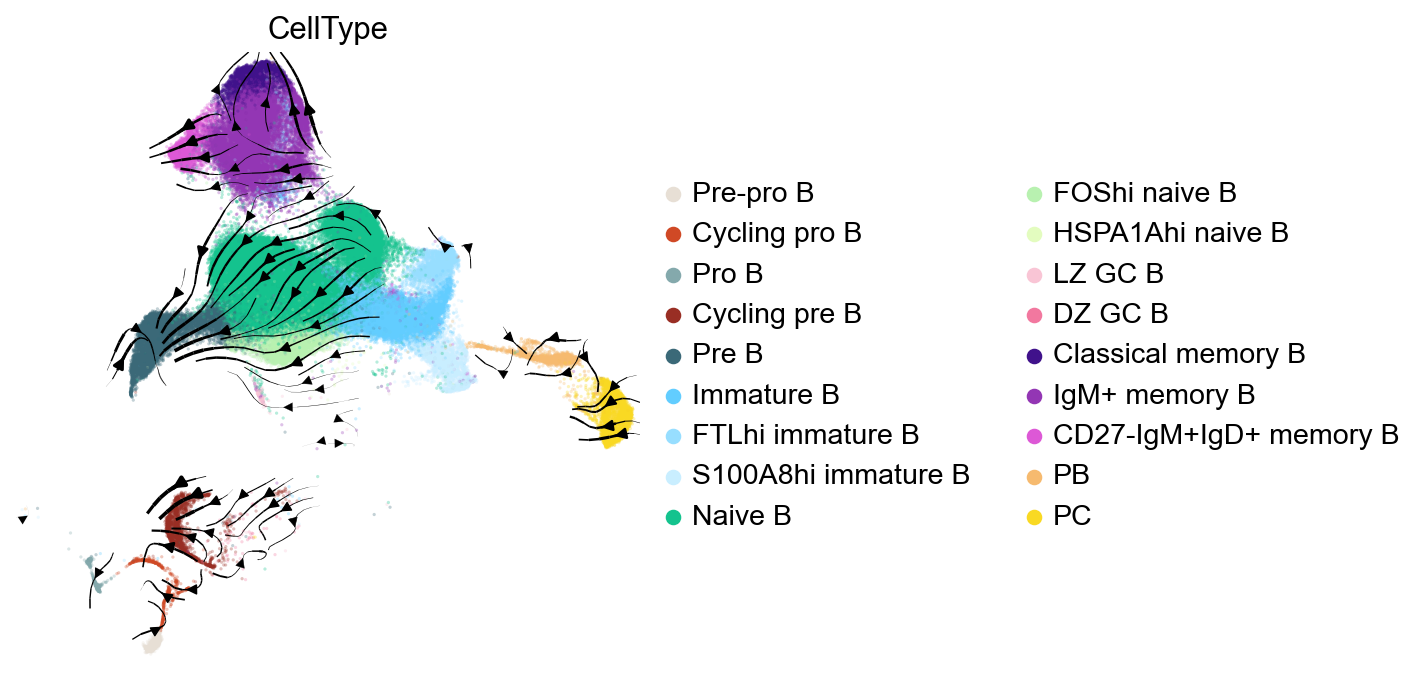

In [41]:
ax = scv.pl.velocity_embedding_stream(adata_merge, basis='umap', color='CellType', figsize=(5,5), 
                                 legend_loc="right margin", show=False)
ax.grid(False)
#plt.savefig("scVelo_bc_proj_clean_20230925.png", bbox_inches="tight", dpi=300)

In [42]:
# Speed and coherence
scv.tl.velocity_confidence(adata_merge)

--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


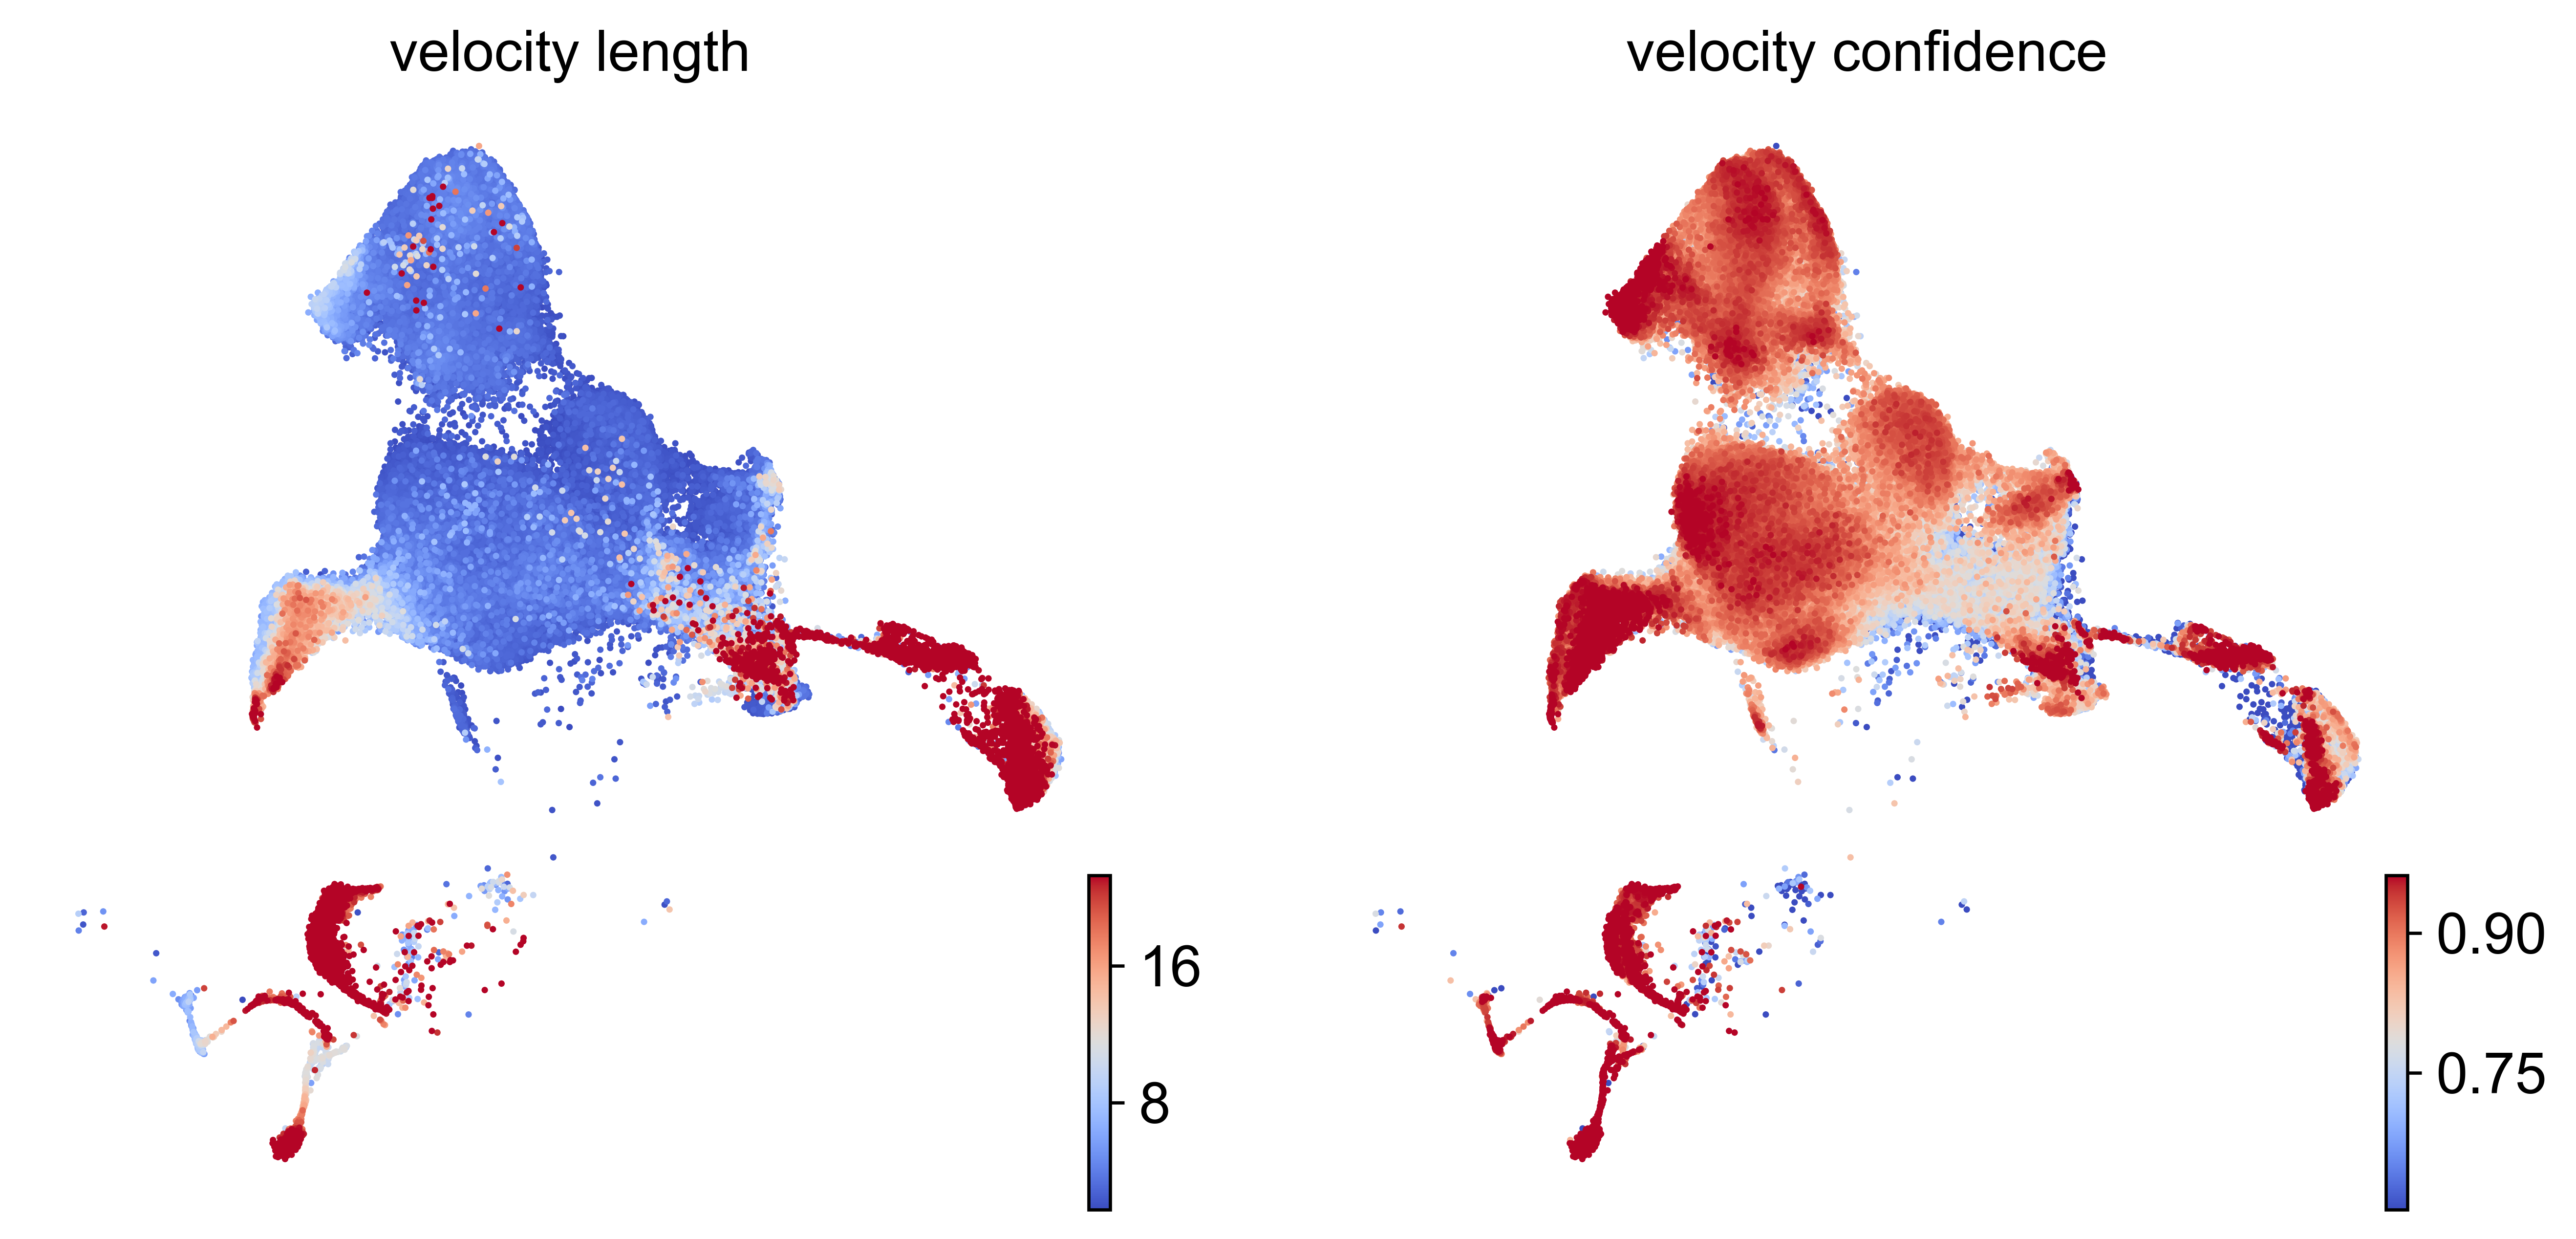

In [43]:
keys = 'velocity_length', 'velocity_confidence'
axes = scv.pl.scatter(adata_merge, c=keys, cmap='coolwarm', perc=[5, 95], figsize=(5.2,5), size=10, dpi=300, show=False)
axes[0].grid(False)
axes[1].grid(False)
#plt.savefig("velocity_length_confidence.png", dpi=300, bbox_inches="tight")

In [44]:
df = adata_merge.obs.groupby('CellType')[keys].mean().T
df.loc[:,[x for x in df.columns if x not in ["DZ GC B", "LZ GC B", "PC"]]].style.background_gradient(cmap='coolwarm', axis=1)

CellType,Pre-pro B,Cycling pro B,Pro B,Cycling pre B,Pre B,Immature B,FTLhi immature B,S100A8hi immature B,Naive B,FOShi naive B,HSPA1Ahi naive B,Classical memory B,IgM+ memory B,CD27-IgM+IgD+ memory B,PB
velocity_length,24.941710,17.458601,6.846975,33.825596,9.232832,3.339715,2.741778,9.997765,2.235774,2.533918,2.850923,3.347857,2.839718,4.842945,80.021347
velocity_confidence,0.995676,0.956980,0.917951,0.934052,0.884653,0.665887,0.823688,0.747248,0.846272,0.836483,0.683836,0.898385,0.861517,0.913821,0.829494


In [45]:
# Pseudotime inference without need of specifying the root cells
scv.tl.velocity_pseudotime(adata_merge)

computing terminal states
    identified 9 regions of root cells and 3 regions of end points .
    finished (0:01:52) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


In [46]:
# Store the default pseudotime inference result
adata_merge.obs["velocity_pseudotime_default"] = adata_merge.obs["velocity_pseudotime"]

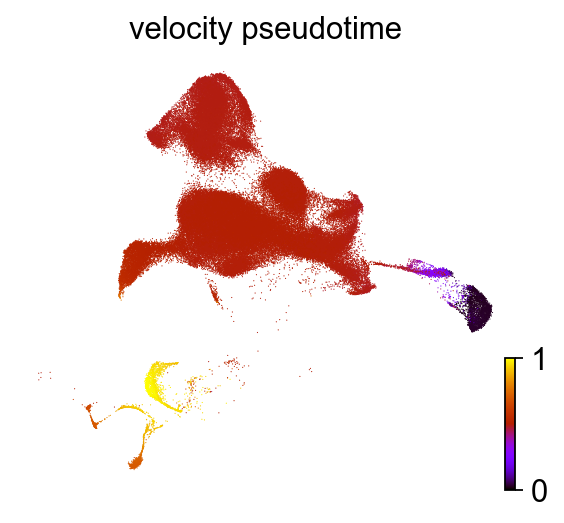

In [47]:
# This result indicate an relatively quiescent state of immature/naive/memory subset
# The pseudotime was reversed
ax = scv.pl.scatter(adata_merge, color='velocity_pseudotime', cmap='gnuplot', figsize=(4,3.6), show=False)
ax.grid(False)

In [48]:
adata_merge.obs["velocity_pseudotime"].sort_values().index[0]

'R-CHEN-BB2-TCTTTCCGTAGGGTAC-1'

In [49]:
# Reverse the pseudotime inferred by default parameters
s = adata_merge.obs.index.tolist().index(adata_merge.obs["velocity_pseudotime_default"].sort_values().index[-1])  # hd2.cd19_ACGGGCTCACGTAAGG-1
e = adata_merge.obs.index.tolist().index(adata_merge.obs["velocity_pseudotime_default"].sort_values().index[0])  # R-CHEN-BB2-TCTTTCCGTAGGGTAC-1
scv.tl.velocity_pseudotime(adata_merge, root_key=s, end_key=e)
adata_merge.obs["velocity_pseudotime_rev"] = adata_merge.obs["velocity_pseudotime"]

In [50]:
# Explictly set the root cell to be a random selection of pre-pro B cells
median_value = adata_merge.obs["velocity_pseudotime_default"][adata_merge.obs["CellType"] == "Pre-pro B"].median()
root_cell = adata_merge.obs_names[adata_merge.obs.velocity_pseudotime_default==median_value][0]
end_cell = "R-CHEN-BB2-TCTTTCCGTAGGGTAC-1"

s = adata_merge.obs.index.tolist().index(root_cell)
e = adata_merge.obs.index.tolist().index(end_cell)

scv.tl.velocity_pseudotime(adata_merge, root_key=s, end_key=e)

In [51]:
adata_merge.obs["velocity_pseudotime_tuned"] = adata_merge.obs["velocity_pseudotime"]

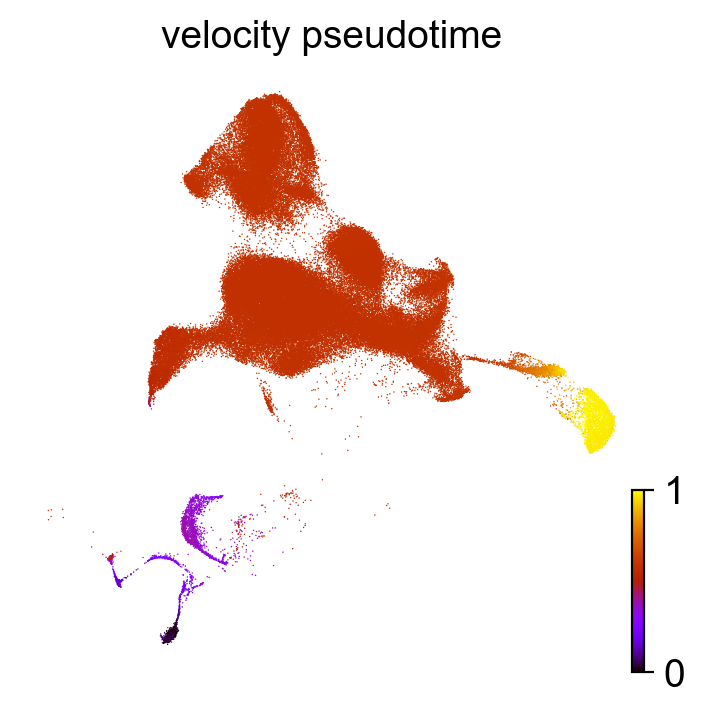

In [52]:
ax = scv.pl.scatter(adata_merge, color='velocity_pseudotime', cmap='gnuplot', figsize=(4,4), show=False,
              dpi=100)
ax.grid(False)

In [53]:
# Export the metadata table
adata_merge.obs.to_csv("adata_merge_obs_metadata.csv")